# CA2 - Luke Kirwan

First, import the relevant modules. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import math

Read in the time series data. 

In [2]:
amazon_data = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
amazon_data.head()

,Close
Date,
2021-01-04,3186.629883
2021-01-05,3218.510010
2021-01-06,3138.379883
2021-01-07,3162.159912
2021-01-08,3182.699951


## 1) (5 points) show a chart to visualize the closed stock price from 04/Jan/2021 to 30/Dec/2021 and write some observations based on this chart.

In [3]:
# Take the subset of the data that is relevant
plot_data = amazon_data['2021-01-04':'2021-12-30']

window_size = 7
shifted = plot_data.shift(window_size-1)
window = plot_data.rolling(window=window_size)
mean = window.mean()

plot_data['7 day rolling average'] = mean

plot_data.head(10)


/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Close,7 day rolling average
Date,,
2021-01-04,3186.629883,NaN
2021-01-05,3218.510010,NaN
2021-01-06,3138.379883,NaN
2021-01-07,3162.159912,NaN
2021-01-08,3182.699951,NaN
2021-01-11,3114.209961,NaN
2021-01-12,3120.830078,3160.488525
2021-01-13,3165.889893,3157.525670
2021-01-14,3127.469971,3144.519950


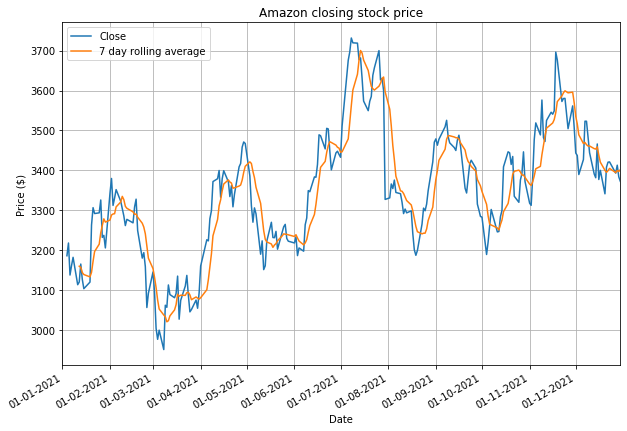

In [4]:
ax = plot_data.plot(figsize=[10,7])
ax.grid('on')
ax.set_title('Amazon closing stock price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_xlim([datetime.date(2021, 1, 1), datetime.date(2021, 12, 30)])
ax.figure.autofmt_xdate()
ax.figure.savefig('plots/amzn_stats.png')

## 2) (5 points) What are the characteristics of a stationary time series? Is this time series data in AMZN.csv likely to be stationary and why? Check it with the naked eye.

In [5]:
plot_data

,Close,7 day rolling average
Date,,
2021-01-04,3186.629883,NaN
2021-01-05,3218.510010,NaN
2021-01-06,3138.379883,NaN
2021-01-07,3162.159912,NaN
2021-01-08,3182.699951,NaN
...,...,...
2021-12-23,3421.370117,3405.157192
2021-12-27,3393.389893,3394.741455
2021-12-28,3413.219971,3399.855748


/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


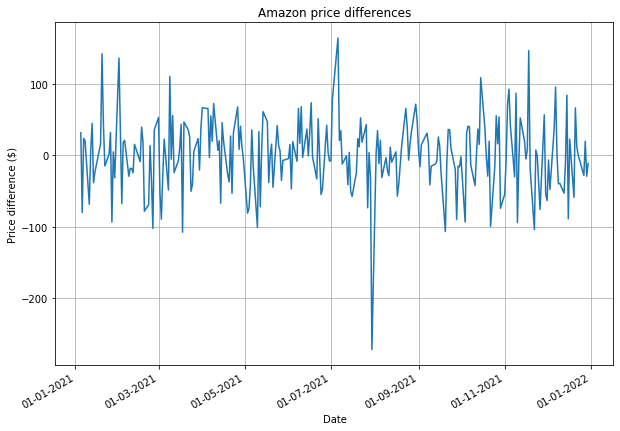

In [6]:
plot_data['Difference'] = plot_data['Close'].diff()
diff_data = plot_data.iloc[1:]

ax2 = diff_data.plot(y='Difference', figsize=[10,7], legend=False)
ax2.grid('on')
ax2.set_title('Amazon price differences')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price difference ($)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.figure.autofmt_xdate()
ax2.figure.savefig('plots/amzn_diff.png')

## 3) (5 points) Summarise the process of calculating autocorrelation function and partial autocorrelation function with mathematical formulations.

Autocorrelation is the correlation of a time series with itself at a different point in time, as a function of the lag between the times. As such, for a time series which is closely correlated with recent values but not related to distant points, the autocorrelation will shrink as the time lag increases. There are two ways of measuring autocorrelation of a time series: the autocorrelation function (ACF) and the partial autocorrelation function (PACF). 

The ACF is used to determine the Pearson correlation coefficient between values at different times. For a given lag k, and time series y1, ..., yn, the formula for the ACF is: 

One issue with the ACF is that it includes the correlation introduced by all of the intermediate values between two times in a time series. The PACF removes these intermediate correlations and focuses on the direct correlation between two values of a time series. Calculating the PACF is somewhat more complicated than calculating the ACF, however it gives us a better insight into the dependence of a time series on its past values, since the PACF will disappear much faster than the ACF for time series with low temporal dependence. This helps us determine the best order of a time series model, such as an autoregressive model. For a given lag k, the partial autocorrelation of y_t with y_t-k is:



## 4) (10 points) Plot the predicted and true stock price with the autoregressive (AR) model on a test set and describe your observations from this plot. Requirements: 1) You need to list key steps and their results (e.g., PACF plot) to predict the stock price. You will lose marks if you only show the final plot about prediction; 2) You need to split this dataset into a train (70%) set and a test (30%) set. Use the train set to train an autoregressive (AR) model and make a prediction on the test set; 3) You need to implement the AR model from scratch rather than using the existing Python library.

In [8]:
# First part
# Modify the AR function given to us in labs
def AR(p, df):
    df_temp = df

    # Generating the lagged p terms
    for i in range(1, p+1):
        df_temp['Shifted_values_%d' % i] = df_temp['Close'].shift(i) # Modification here: change to 'Close'

    train_size = (int)(0.7 * df_temp.shape[0]) # Modification here: change training size to 0.7

    # Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    # X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:, 1:].values.reshape(-1, p)
    # Y contains the value,it is the first column
    y_train = df_train_2.iloc[:, 0].values.reshape(-1, 1)

    # Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    theta = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:, 1:].values.reshape(-1, p)
    df_test['Predicted_Values'] = X_test.dot(theta) + intercept
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(
        df_test['Close'], df_test['Predicted_Values'])) # Modification here: change to 'Close'

    print("The RMSE is :", RMSE, ", Value of p : ", p)
    return [df_train_2, df_test, theta, intercept, RMSE]


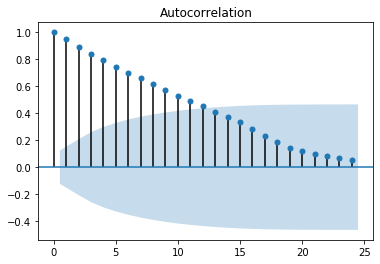

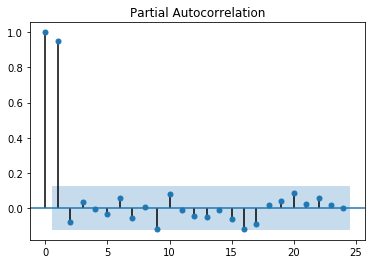

In [9]:
# Plot the PACF to determine the best lag to use for the AR model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(amazon_data)
pacf_fig = plot_pacf(amazon_data)
pacf_fig.savefig('plots/pacf_diff.png')
# plot_acf(diff_data.Difference)
# plot_pacf(diff_data.Difference)

Use a lag of 1

In [10]:
# Train the AR model using the observed lag
# Try a few different values for the lag (lag = 1,2,3)
lag = 1
[df_train,df_test,theta,intercept,RMSE] = AR(lag, amazon_data)

The RMSE is : 51.72335860705081 , Value of p :  1


/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
print(theta)
print(intercept)
# Model is of the form y_t = theta * y_(t-1) + intercept
df_test.head()

[[0.95730717]]
[142.88871766]


,Close,Shifted_values_1,Predicted_Values
Date,,,
2021-09-14,3450.000000,3457.169922,3452.462284
2021-09-15,3475.790039,3450.000000,3445.598467
2021-09-16,3488.239990,3475.790039,3470.287456
2021-09-17,3462.520020,3488.239990,3482.205883
2021-09-20,3355.729980,3462.520020,3457.583971


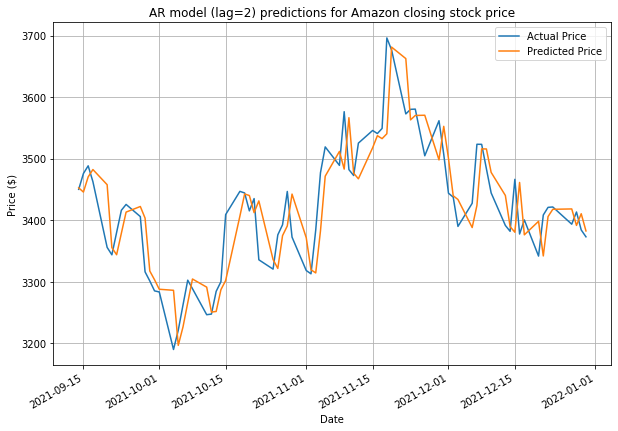

In [13]:
# Plot predictions
plot_test_df = df_test.drop(columns=['Shifted_values_1'])

ax3 = plot_test_df.plot(figsize=[10,7])
ax3.set_title('AR model (lag=2) predictions for Amazon closing stock price')
ax3.grid('on')
ax3.set_ylabel('Price ($)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax3.figure.autofmt_xdate()
L=ax3.legend()
L.get_texts()[0].set_text('Actual Price')
L.get_texts()[1].set_text('Predicted Price')
ax3.figure.savefig('plots/ar_model_2.png')


## 5) (5 points) What are the strengths and weaknesses of the AR model? Are there some ways to overcome such weaknesses?

One of the key strengths of AR models is their simplicity. They are easy to use and quick to learn, and there are tried and tested techniques for computing the optimal parameters.

Another benefit is that we can create a model for predicting future values based purely on past values. This is a powerful tool and can be used as a ’base’ for more complex models which might incorporate external factors.

The main weakness of AR models is that they only take the current error into account, and not past errors. Thus, if there is a correlation between the error terms, an AR model will not use this information. One way we can overcome this weakness is by using Moving Average (MA) models. MA models use past errors in a regression like model, and can be combined with AR models to make more powerful models.